# Projektarbeit

Notiz:
Der Code im Jupyter-Notebook wurde mit VSC und der Erweiterung Autopep8 formatiert.

In [1]:
import pandas as pd
import numpy as np
from sklearn import neural_network
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from os import path
import seaborn as sns

In [2]:
feather = "data/accesspoints.pkl"
if not path.exists(feather):
    csv_name = "data/creditcard_2023.csv"
    print(feather, "does not exist, reading", csv_name, "instead")
    df = pd.read_csv(csv_name)
    df.to_feather(feather)
else:
    print("reading", feather)
    df = pd.read_feather(feather)
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

reading data/creditcard_2023.feather


##### Beschreibung der Daten
Der vorliegende Datensatz enthält Kreditkartentransaktionen europäischer Karteninhaber im Jahr 2023.  
Die Daten wurden zum Schutz der Kreditkarteninhaber anonymisiert.  
Der Datensatz enthält insgesamt 31 Spalten und 568630 Zeilen.  
Die erste Spalte enthält eine eindeutige Kennzeichnung der jeweiligen Transaktion durch eine ID.  
Transaktionsattribute wie die Zeit und der Standort der Transaktion werden durch die Spalten V1-V28 repräsentiert. Diese Informationen wurden anonymisiert.  
Die vorletzte Spalte gibt Information über den Geldbetrag der Transaktion.  
Zuletzt gibt die Spalte 'Class' Auskunft darüber, ob die Transaktion betrügerisch ist (1), oder nicht (0).

Die Spalten des Datensatzes enthalten lediglich numerische Datentypen.  
Es gibt im gesamten Datensatz keine fehlenden Werte.

In [3]:
# Zeilen, Spalten des Dataframes anzeigen lassen
print(df.shape)

# Spalten mit fehlenden Werten
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
if columns_with_missing_values.empty:
    print("Es gibt keine Spalten mit fehlenden Werten.")
else:
    print("Spalten mit fehlenden Werten:")
    print(columns_with_missing_values)

# Daten auf nur numerische Werte prüfen
data_types = df.dtypes
are_numeric = all(data_types.apply(lambda x: pd.api.types.is_numeric_dtype(x)))
if are_numeric:
    print("Alle Spalten enthalten numerische Werte.")
else:
    print("Es gibt nicht-numerische Werte in mindestens einer Spalte.")

# Ersten 5 Zeilen des Dataframes anzeigen lassen
selected_columns = ['id', 'V1', 'V2', 'V3', 'Amount', 'Class']
df[selected_columns].head(5)

(568630, 31)
Es gibt keine Spalten mit fehlenden Werten.
Alle Spalten enthalten numerische Werte.


,id,V1,V2,V3,Amount,Class
0,0,-0.260648,-0.469648,2.496266,17982.10,0
1,1,0.985100,-0.356045,0.558056,6531.37,0
2,2,-0.260272,-0.949385,1.728538,2513.54,0
3,3,-0.152152,-0.508959,1.746840,5384.44,0
4,4,-0.206820,-0.165280,1.527053,14278.97,0


##### Statistische Merkmale
Die Betrachtung der Spalte 'id' ist für diesen Abschnitt irrelevant, da diese einfach nur pro Zeile um 1 inkrementiert wird.  

In den Spalten V1-V28 kann man erkennen, dass die Standardabweichung jeweils bei etwa 1.0 liegt und der Mittelwert bei knapp 0.0.  
Dies deutet darauf hin, dass die Daten bereits standardisiert wurden und wir dies nicht mehr unternehmen müssen.  
Lediglich die Spalte 'Amount' wurde nicht standardisiert.  
Die Geldbeträge der Transaktionen liegen zwischen 50 und 24.000€, wobei der Mittelwert bei 12.000€ liegt.

In [4]:
df[selected_columns].describe()

,id,V1,V2,V3,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,24039.930000,1.0


##### Korrelationsmatrix
Im Folgenden stellen wir die Korrelationsmatrix für unseren Datensatz dar, um die linearen Beziehungen der Spalten zu betrachten.  
Da die Korrelationsmatrix durch die vielen Spalten sehr unübersichtlich ist, beschränken wir uns in der zweiten Abbildung auf die starken Korrelationen.  
Es werden jeweils in roten Farben die positiven Korrelationen und in blauen Farben die negativen Korrelationen dargestellt. 

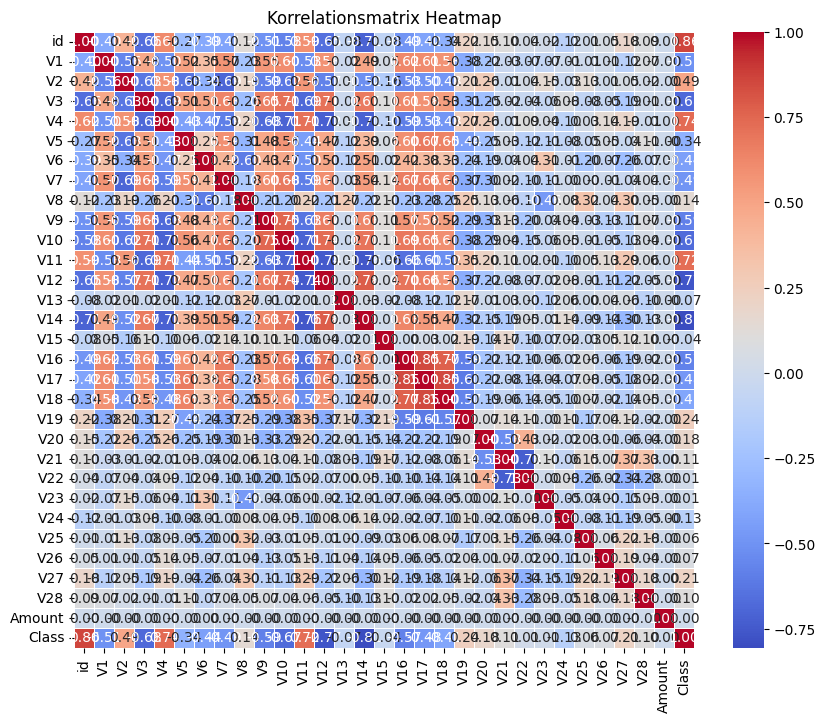

In [5]:
# Korrelationsmatrix
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix Heatmap')
plt.show()

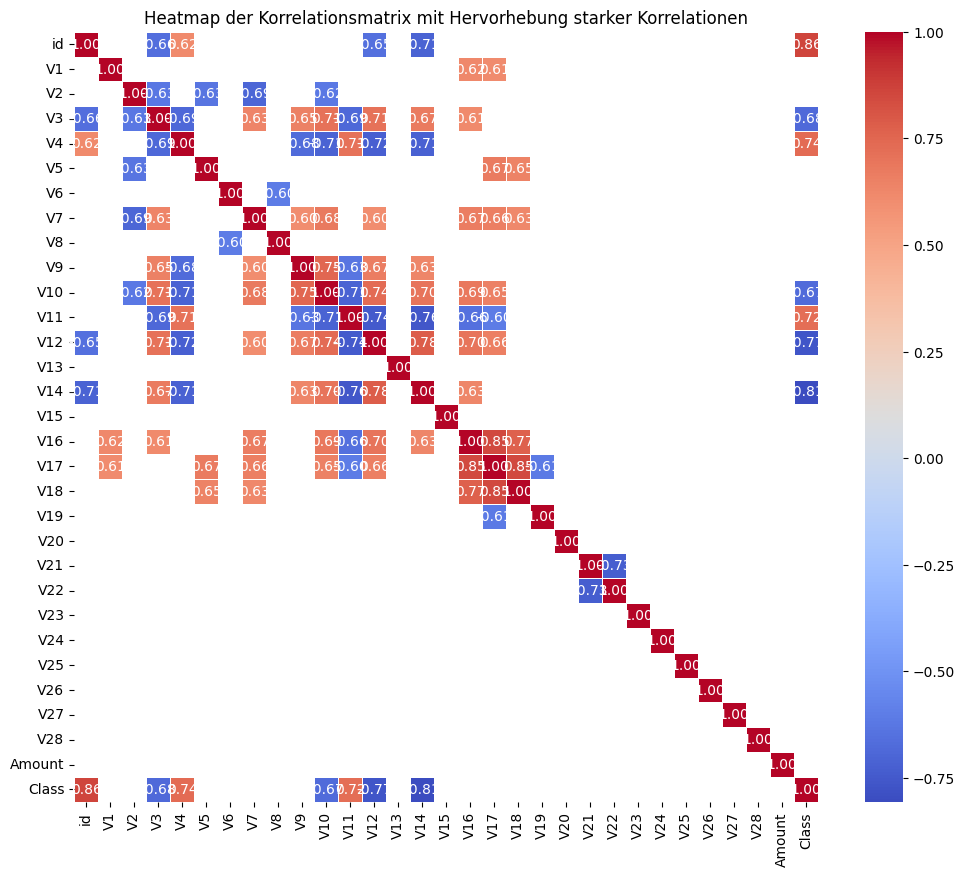

In [6]:
# Heatmap mit Hervorhebung starker Korrelationen
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap der Korrelationsmatrix mit Hervorhebung starker Korrelationen')
plt.show()

##### Scatterplots der wichtigsten Korrelationen

Nun schauen wir uns die Scatterplots der Spalten an, die hohe Korrelationen enthalten.  
Zuerst sehen wir, dass es einen Zusammenhang zwischen der id und dem Label 'Class' gibt.  
Aus der Abbildung kann man entnehmen, dass in der zweiten Hälfte des Datensatzes, also die ID's von 250.000-500.000 deutlich mehr betrügerische Transaktionen halten, als die erste Hälfte.  
Daraus können wir schließen, dass die Spalte 'id' für die Modellbildung entfernt werden sollte, da man für zukünftige Datensätze nicht von einer ähnlichen Korrelation ausgehen kann.

Des Weiteren gibt es einen Zusammenhang zwischen den Spalten 'V14' und 'Class' sowie 'V12' und 'Class'.  
Man kann jeweils sehen, dass die betrügerischen Transaktionen in einem bestimmten Bereich der Features sind.  
Wir können also erwarten, dass diese zwei Features für unsere Modellbildung von großer Bedeutung sein werden.

Zuletzt sehen wir einen linearen Zusammenhang zwischen 'V17' und 'V16'.  
Zu Erkennen ist, dass mit einer Zunahme von 'V16' auch 'V17' leicht zunimmt.  
Da die Daten allerdings anonymisiert sind und wir keine näheren Informationen zu diesem Datensatz haben, können wir keine weiteren Schlüsse ziehen.

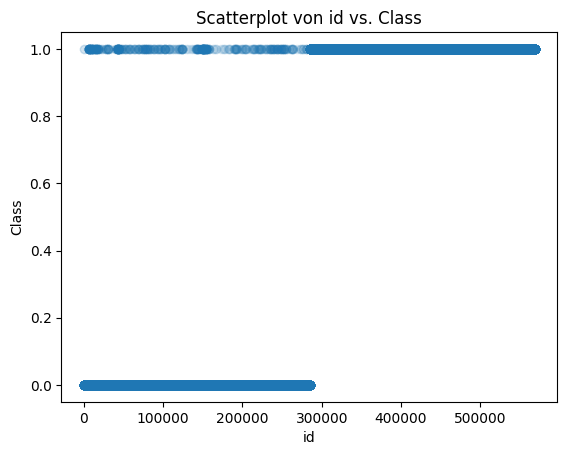

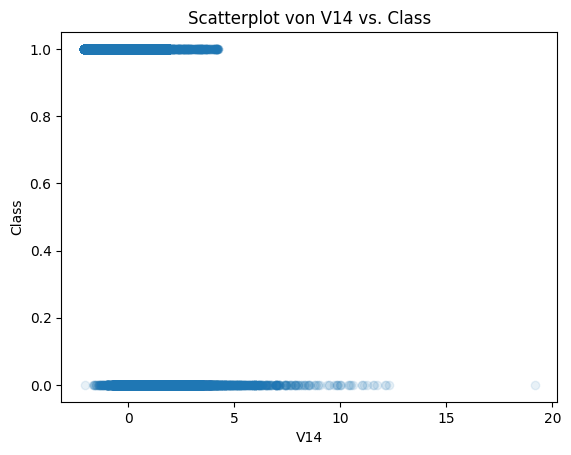

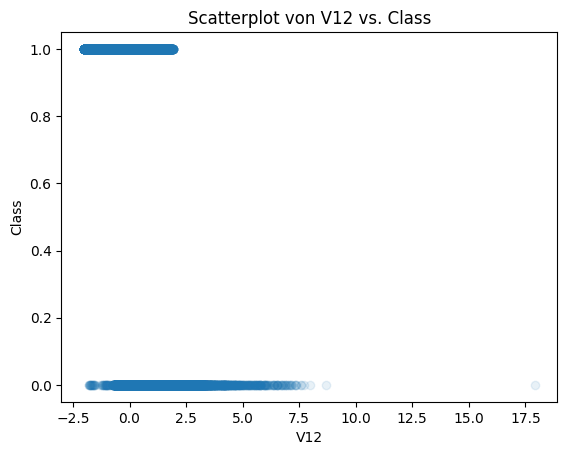

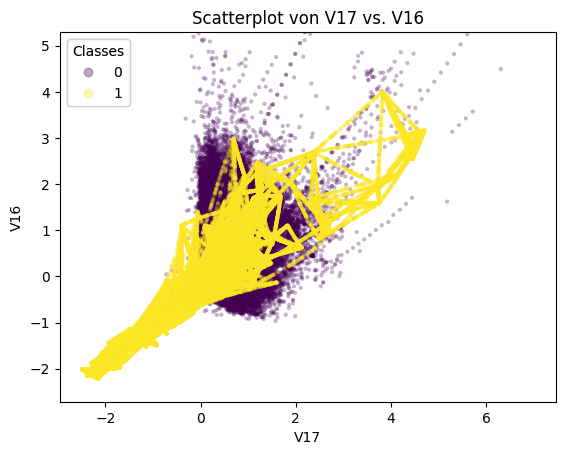

In [7]:
# Scatterplots der folgenden Spalten:
# id und Class
# V14 und Class
# V12 und Class
# V17 und V16
columns_to_plot = [('id', 'Class'), ('V14', 'Class'), ('V12', 'Class'), ('V17', 'V16')]


# produce a legend with the unique colors from the scatter
for column_x, column_y in columns_to_plot:
    fig, ax = plt.subplots()
    if column_x == "V17":
        scatter = ax.scatter(df[column_x], df[column_y], alpha=0.3, c=df['Class'], edgecolors='none', marker=".")
        legend1 = ax.legend(*scatter.legend_elements(),
                            loc="best", title="Classes")
        ax.add_artist(legend1)
        plt.ylim(df[column_y].quantile(0)-0.5, df[column_y].quantile(0.9999))

    else:
        plt.scatter(df[column_x], df[column_y], alpha=0.1)
        pass
    plt.title(f'Scatterplot von {column_x} vs. {column_y}')
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

##### Ausreißer

Als nächstes stellen wir die Ausreißer mit Hilfe von Boxplots dar.  
In diesem Abschnitt verwenden wir den Interquantilsabstand (IQR), um die Anzahl an Ausreißer auszugeben.  
Der IQR ist die Differenz zwischen dem dritten Quantil (Q3) und dem ersten Quantil (Q1) einer Verteilung.  
Die typische Regel ist, dass Werte außerhalb des Bereichs $[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]$ als Ausreißer betrachtet werden.

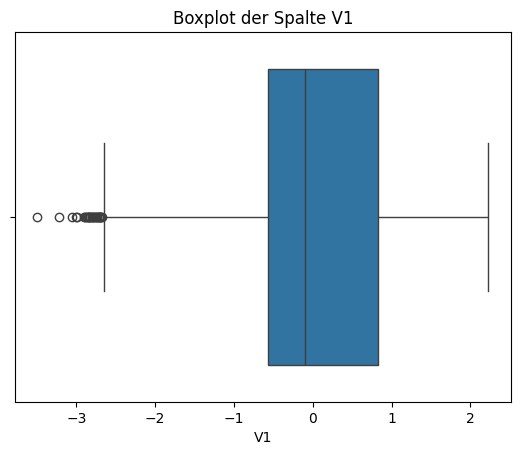

Ausreißer in Spalte 'V1':
30


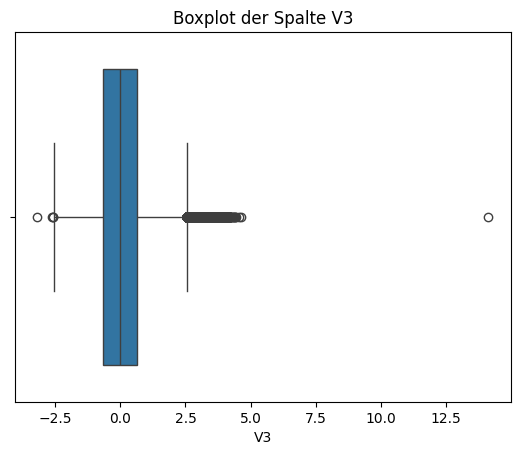

Ausreißer in Spalte 'V3':
4300


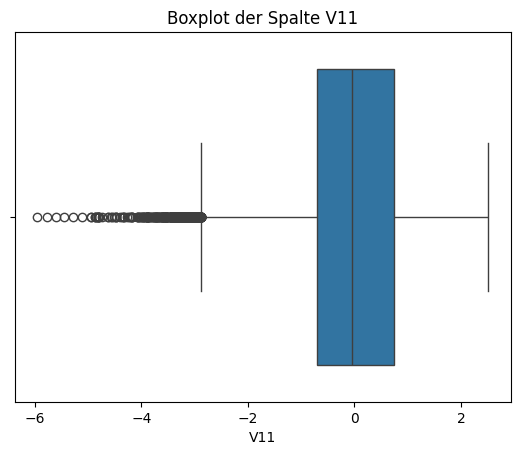

Ausreißer in Spalte 'V11':
709


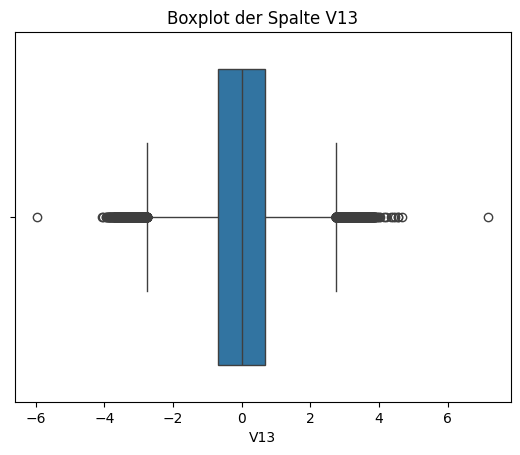

Ausreißer in Spalte 'V13':
4197


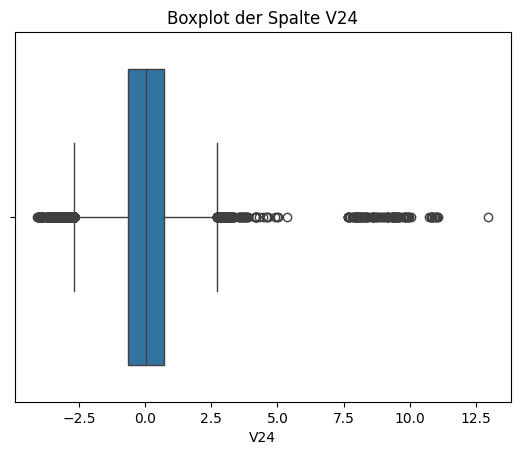

Ausreißer in Spalte 'V24':
2029


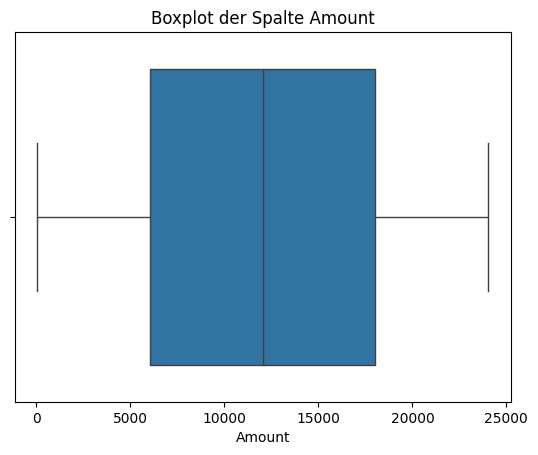

Ausreißer in Spalte 'Amount':
0


In [8]:
# Ausreißer herausfiltern
column_names = ['V1', 'V3', 'V11', 'V13', 'V24', 'Amount']

for column_name in column_names:
    sns.boxplot(x=df[column_name])
    plt.title(f'Boxplot der Spalte {column_name}')
    plt.show()

    # IQR berechnen
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Ausreißer filtern
    outliers = df.loc[(df[column_name] < Q1 - 1.5 * IQR) | (df[column_name] > Q3 + 1.5 * IQR), ['id']]
    print(f"Ausreißer in Spalte '{column_name}':")
    print(len(outliers))

##### Principal Component Analysis (PCA)
Nachfolgend führen wir eine Principal Component Analysis (PCA) durch.  
Die Ausgabe zeigt die kumulative Summe der erklärten Varianzanteile für jede Hauptkomponente.  
Die Tabelle zeigt den Beitrag jeder einzelnen Spalte zu dieser kumulativen Summe.

Die ersten Hauptkomponenten tragen einen erheblichen Teil der ursprünglichen Information in den Daten bei.  
In diesem Datensatz erklären die ersten 10 Hauptkomponenten etwa 70% der Gesamtvarianz.


    Explained Variance Ratio Column Name
0                   0.341434          id
1                   0.094057          V1
2                   0.066084          V2
3                   0.062338          V3
4                   0.043929          V4
5                   0.036293          V5
6                   0.034464          V6
7                   0.033333          V7
8                   0.029024          V8
9                   0.027567          V9
10                  0.025395         V10
11                  0.020949         V11
12                  0.018957         V12
13                  0.016917         V13
14                  0.016570         V14
15                  0.014852         V15
16                  0.013424         V16
17                  0.012816         V17
18                  0.011816         V18
19                  0.011279         V19
20                  0.009451         V20
21                  0.008646         V21
22                  0.007950         V22
23              

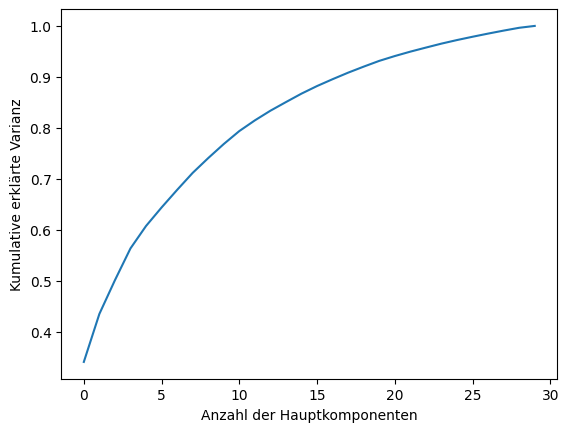

In [9]:
# PCA
from sklearn.decomposition import PCA

features = df.iloc[:, :-1]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

pca = PCA()
pca_result = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

column_names = features.columns
variance_df = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio, 'Column Name': column_names})

variance_df_sorted = variance_df.sort_values(by='Explained Variance Ratio', ascending=False)

print(variance_df_sorted)

cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(cumulative_explained_variance)
plt.xlabel('Anzahl der Hauptkomponenten')
plt.ylabel('Kumulative erklärte Varianz')
plt.show()

Nun wird eine Schranke festgelegt, wodurch wir die Hauptkomponenten entnehmen, die 95% der Varianz ausmachen.  
Dadurch können wir feststellen, dass die Features V23-V28 sowie Amount nur 5% der Varianz ausmachen.  
Somit könnten wir diese für unsere Modellbildung entfernen, um das Modell zu performieren.

In [10]:
# Finde die Anzahl der Hauptkomponenten, die 95% der Varianz erklären
num_components_95_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Extrahiere die relevanten Hauptkomponenten
selected_pca_components = pca_result[:, :num_components_95_variance]

# Erstelle ein DataFrame für die ausgewählten Hauptkomponenten
selected_pca_df = pd.DataFrame(selected_pca_components, columns=[f'PC{i+1}' for i in range(num_components_95_variance)])

# Spaltennamen des ursprünglichen DataFrames
original_columns = features.columns

# Gebe die Spaltennamen der ausgewählten Hauptkomponenten
print("Spaltennamen der ausgewählten Hauptkomponenten:")
print(original_columns[:num_components_95_variance])

Spaltennamen der ausgewählten Hauptkomponenten:
Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22'],
      dtype='object')


### Data Preparation
Nun kümmern wir uns darum, unseren Datensatz aufzubereiten, damit wir bestmögliche Ergebnisse für unsere Modelle erzielen können.  

Da wir keine leere Spalten oder Nullwerte im Datensatz haben, müssen diese nicht weiter berücksichtigt werden.  
Auch eine Standardisierung unserer Daten muss nicht erfolgen, da die Spalten V1-V28 bereits standardisiert sind.  

Wie aus unserer Analyse der Korrelationen zwischen den Spalten zu entnehmen, müssen wir die 'id' aus unserem Datensatz für die Modellbildung entfernen, da wir nicht davon ausgehen können, dass in zukünftigen Datensätzen die gleiche Korrelation vorliegt, dass betrügerische Transaktionen vor allem mit höheren ID's vorliegen.

Des Weiteren haben wir in unserer PCA herausgefunden, dass die Spalten V23-V28 sowie die Spalte Amount nur einen geringen Anteil der Varianz ausmacht.  
Dementsprechend werden auch diese entfernt, damit das Modell deutlich performanter ist.

Außerdem verwenden wir eine Labelkodierung, um die Werte unseres Labels von kategorischen zu numerischen Werten umzuwandeln

In [11]:
# id ist für die Vorhersage nicht notwendig
# V23-V28 sowie Amount werden aufgrund der geringen Varianz entfernt
columns_to_keep = [col for col in df.columns if col not in ['id'] + [f'V{i}' for i in range(23, 29)] + ['Amount']]
df = df[columns_to_keep]

# Label von kategorischen in numerischen Wert umwandeln
lab = preprocessing.LabelEncoder()
df.iloc[:, -1] = lab.fit_transform(df.iloc[:, -1])

Bei der Datenbetrachtung haben wir uns bereits einige der Spalten mit Ausreißern angeschaut.  
Diese beseitigen wir nachfolgend indem wir sie mit dem Median-Wert der jeweiligen Spalte ersetzen.  
Dies hat den Vorteil, dass der Median robust gegenüber Ausreißern ist und im Gegensatz zum Mittelwert weniger anfällig für extreme Abweichungen ist.

In [12]:
column_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22']

for column_name in column_names:
    # IQR berechnen
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Ausreißer durch Median ersetzen
    median_value = df[column_name].median()
    df2 = df.copy(deep=True)
    df2.loc[(df[column_name] < Q1 - 1.5 * IQR) | (df[column_name] > Q3 + 1.5 * IQR), column_name] = median_value

Zuletzt teilen wir unsere Daten in Trainings- und Testdaten auf, damit wir unser Modell mit den Trainingsdaten trainieren können und dann mit den Testdaten unabhängig die Fähigkeit des Modells auf neue, nicht gesehene Daten überprüfen können.  
Dafür wird der Datensatz zuerst randomisiert, worauf wir dann die Daten in 80% Trainings- und 20% Testdaten aufteilen.

In [13]:
# Splitten in Test- und Trainingsdatensatz
df = df.sample(frac=1, random_state=1)

x_ges = df.iloc[:, :-1].to_numpy()
y_ges = df.iloc[:, -1]
y_labeled = df.iloc[:, -1].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    x_ges, y_labeled, test_size=0.2, random_state=12)

### Modeling
Weil einige Algorithmen wie SVM oder RandomForest mit hoher `max_depth` und `n_estimators` sehr lange brauchen, werden sie hier erst nur defined und es werden nicht alle Algorithmen auf dem gesamten Datensatz ausgeführt.

Wenn der Jupyter Kernel neu gestartet wird, muss außerdem das gesamte Notebook nochmal berechnet werden, und da ist es von Vorteil wenn die Methodenaufrufe wie `compute_randomforest_classifier()` auskommentiert sind, damit das Notebook in unter 2 Minuten durchläuft.  
Wegen hohen Arbeitsspeicherkosten wird z.B. das große Dataframe `df` durch das kleinere mit 20000 Zeilen ersetzt.   
Das Splitten in Test- und Trainingsdatensatz wurde ausgelagert, auch um die Messungen etwas genauer zu gestalten, ohne dass in jede "Compute-Methode" einzeln `time.time()` zu programmieren.   

In [14]:
import seaborn
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


def compute_randomforest_classifier(df=df, n_estimators=100, max_depth=None, random_state=56, plot_decisionboundary=True):
    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))

    return clf, train_accu, test_accu


def compute_randomforest_classifier_with_fancy_pictures(df=df, n_estimators=100, max_depth=None, random_state=56, plot_decisionboundary=True):
    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))
    y_prediction_test = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_prediction_test)
    plt.set_cmap("gray")
    cm_display = ConfusionMatrixDisplay(cm).plot()
    # seaborn.heatmap(cm,annot=True,xticklabels=("True","False"),yticklabels=("True","False"))
    report = classification_report(lab.inverse_transform(
        y_test), lab.inverse_transform(y_prediction_test), digits=5)
    print(report)
    plt.show()


# random_tree = compute_randomforest_classifier(max_depth=100, n_estimators=20)[0]

In [15]:
# train accuracy: 99.99978017339922 %
# test accuracy: 99.97889664632538 %
# [[56821    22]
#  [    2 56881]]
#               precision    recall  f1-score   support

#            0     1.0000    0.9996    0.9998     56843
#            1     0.9996    1.0000    0.9998     56883

#     accuracy                         0.9998    113726
#    macro avg     0.9998    0.9998    0.9998    113726
# weighted avg     0.9998    0.9998    0.9998    113726

### randomforest Vergleich von Datensatz mit und ohne Zellen 22-27
vermutlich weil die Zellen nur random sind und dadurch lokale maxima gefunden werden beim Decisiontree? Könnte aber auch nur Zufall sein bei den geringen Unterschieden.
max_depth=100,n_estimators=10, df with all columns       
train accuracy: 99.99560346798445 %     
test accuracy: 99.97713803351917 %      
max_depth=100,n_estimators=10, df without columns 22-27     
train accuracy: 99.99978017339922 %     
test accuracy: 99.97889664632538 %      

In [16]:
import A3utilities


def compute_decisiontree_classifier(max_depth=10, random_state=23, export_decisiontree_graph=True):
    clf = tree.DecisionTreeClassifier(
        max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))

    if (export_decisiontree_graph == True):
        A3utilities.export_decisiontreegraph(
            clf, "Kreditkartenbetrug/Decisiontree", max_depth)
    return clf, train_accu, test_accu


# compute_decisiontree_classifier(max_depth=100)
# print("depth=",decision_tree.get_depth())

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay


def compute_decisiontree_classifier_tree_and_cm(df: pd.DataFrame, max_depth=None, random_state=23):
    clf = tree.DecisionTreeClassifier(
        max_depth=max_depth, random_state=random_state)
    clf.fit(x_train, y_train)
    y_prediction_train = clf.predict(x_train)
    y_prediction_test = clf.predict(x_test)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)

    print("train accuracy: {} %".format(train_accu))
    print("test accuracy: {} %".format(test_accu))

    # f,ax = plt.subplots(1,1,figsize=(50,50))
    # disp=ConfusionMatrixDisplay.from_predictions(lab.inverse_transform(y_test), lab.inverse_transform(y_prediction_test), ax=ax)
    # print(len(lab.classes_))
    # disp.plot()
    # plt.show()
    # print(classification_report(lab.inverse_transform(y_test),
    #       lab.inverse_transform(y_prediction_test), digits=4))
    print("classification_report train:\n",classification_report(y_train, y_prediction_train, digits=4))
    print("classification_report test:\n",classification_report(y_test, y_prediction_test, digits=4))
    plt.show()
    return clf, train_accu, test_accu 


# compute_decisiontree_classifier_tree_and_cm(df, max_depth=100)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import naive_bayes
from sklearn import svm


def compute_naive_bayes():
    # var_smoothing can have a huge influence on the result!
    # smoothies=[1e-9,1e-8,1e-7,1e-6,1e-5,0.0001,0.001,0.01,0.1,0.2,0.4,0.7]
    # for sm in smoothies:
    clf = naive_bayes.GaussianNB(var_smoothing=0.001)
    clf.fit(x_train, y_train)

    train_accu = 100 * clf.score(x_train, y_train)
    test_accu = 100 * clf.score(x_test, y_test)
    return train_accu, test_accu


def compute_svm():
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    train_accu = []
    test_accu = []
    for kern in kernels:
        clf = svm.SVC(kernel=kern, cache_size=200, random_state=0)
        clf.fit(x_train, y_train)
        y_prediction_train = clf.predict(x_train)
        y_prediction_test = clf.predict(x_test)
        train_accu.append(100*accuracy_score(y_train, y_prediction_train))
        test_accu.append(100*accuracy_score(y_test, y_prediction_test))
    return kernels, train_accu, test_accu

# compute_svm()


def compute_nearest_neighbors():
    # unsupervised learning method that does NOT use y_train.
    clf = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')

    clf.fit(x_train)
    # indices
    distances, indices = clf.kneighbors(x_train)
    y_prediction_train = []

    # Also in indices sind die Indexe von x_ges/x_train/y_train, die am nähsten an den Features dran sind.
    # Natürlich bekommen wir dann auch 100% train_accuracy.
    # 
    for i in indices[:, 0]:
        y_prediction_train.append(y_train[i])

    distances, indices2 = clf.kneighbors(x_test)
    y_prediction_test = []
    for i in indices2[:, 0]:
        y_prediction_test.append(y_train[i])

    train_accu = 100*accuracy_score(y_train, y_prediction_train)
    test_accu = 100*accuracy_score(y_test, y_prediction_test)
    # print(train_accu, train_accu2, test_accu, test_accu2)
    return train_accu, test_accu


def compute_KNeighbors_classifier():
    clf = KNeighborsClassifier(n_neighbors=1, algorithm="ball_tree")
    clf.fit(x_train, y_train)
    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)
    return train_accu, test_accu


def compute_nearest_centroid():
    from sklearn.neighbors import NearestCentroid
    centroid_metrics = ["euclidean", "manhattan", "l2"]
    print("x_test.shape=", x_test.shape)

    # return is in the loop right now so we only use euclidean
    for _metric in centroid_metrics:  
        clf = NearestCentroid(metric=_metric)
        clf.fit(x_train, y_train)
        print(clf.score(x_train, y_train))
        y_prediction_train = clf.predict(x_train)
        y_prediction_test = clf.predict(x_test)

        train_accu = 100 * clf.score(x_train, y_train)
        test_accu = 100 * clf.score(x_test, y_test)
        train_accu2 = accuracy_score(y_train, clf.predict(x_train)) #same as train_accu
        print("train accuracy: {} %".format(train_accu))
        print("test accuracy: {} %".format(test_accu))
        print("train accuracy2: {} %".format(train_accu2))
        return train_accu, test_accu


def compute_perceptron(penalty="l2"):
    from sklearn.linear_model import Perceptron
    clf = Perceptron(penalty="l2")
    # clf.partial_fit(x_train, y_train, classes=np.unique(y_train))
    clf.fit(x_train, y_train)
    print("x_test.shape=", x_test.shape)

    train_accu = 100*clf.score(x_train, y_train)
    test_accu = 100*clf.score(x_test, y_test)
    return train_accu, test_accu


def compute_mlp(max_iter=2000):
    mlp = neural_network.MLPClassifier(max_iter=2000)
    mlp.fit(x_train, y_train)
    train_accu = 100*mlp.score(x_train, y_train)
    test_accu = 100*mlp.score(x_test, y_test)
    return train_accu, test_accu


# compute_nearest_centroid()
# compute_mlp()  # takes about 20 minutes
# compute_naive_bayes()
# compute_nearest_neighbors() #scales quadratically? with rows and takes ~4+ hours for the whole dataset
# compute_KNeighbors_classifier()

In [19]:
# takes about 60 minutes for range(1,35)
def random_forest_graphs_by_depth():
    trainAccuHist = []
    testAccuHist = []
    for depth in range(1, 35, 1):
        flower_tree, train_accu, test_accu = compute_randomforest_classifier(
            n_estimators=50, max_depth=depth)
        trainAccuHist = np.append(trainAccuHist, train_accu)
        testAccuHist = np.append(testAccuHist, test_accu)
    print(df.shape)
    print(trainAccuHist)

    _len = len(trainAccuHist)
    a = np.arange(_len)
    plt.plot(a, trainAccuHist,
             label="trainAccuHist", marker='o')
    plt.plot(a, testAccuHist,
             label="testAccuHist", marker='o')
    plt.legend()
    plt.title("Randomforest Classifiers by depth")
    plt.xlabel("depth")
    plt.ylabel("accuracy")
    plt.xlim(15, 50)
    plt.ylim(99.97, 100.01)
    plt.show()
# random_forest_graphs_by_depth()

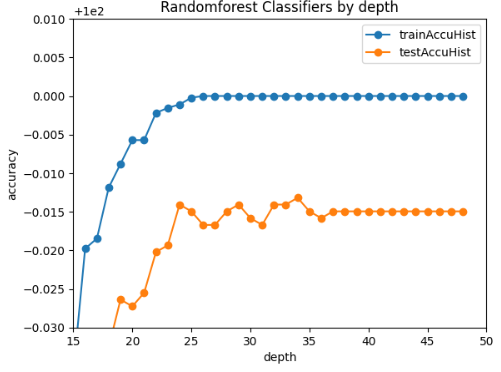
### DecisionTree    
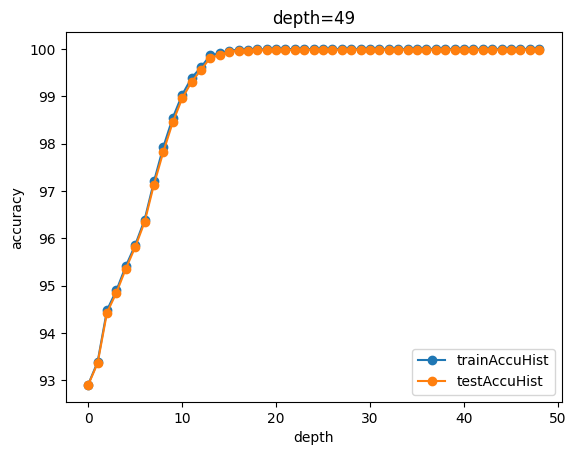    
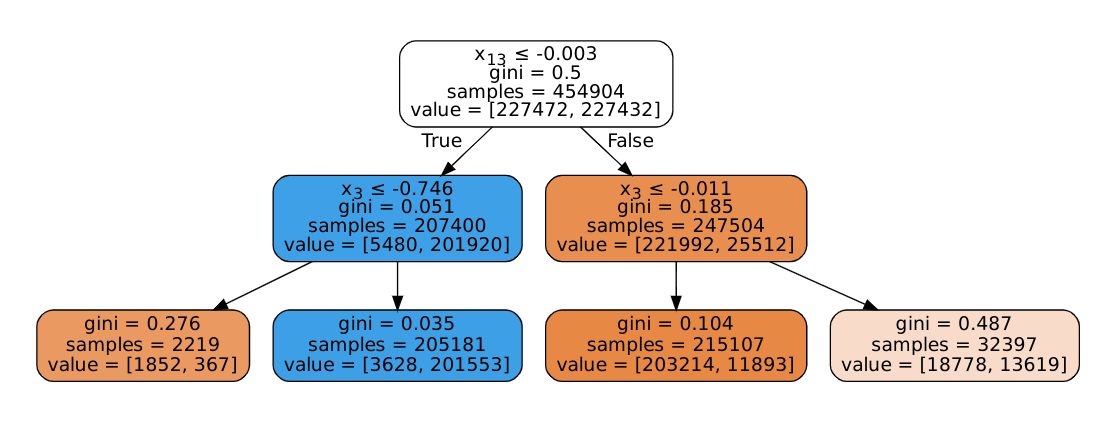      

train accuracy: 100.0 %
test accuracy: 99.98593109755025 %
train accuracy: 100.0 %
test accuracy: 99.79775952728488 %
(99.98285352513938, 99.96570705027874) (RandomForestClassifier(max_depth=100, n_estimators=20, random_state=56), 100.0, 99.98593109755025) (DecisionTreeClassifier(max_depth=100, random_state=23), 100.0, 99.79775952728488)


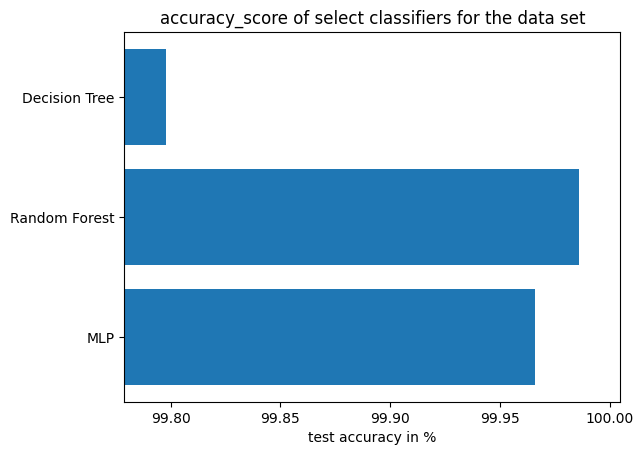

In [21]:
def accuracy_score_whole_dataset_select_classifiers():
    models = ["MLP", "Random Forest", "Decision Tree"]#, "compute_nearest_neighbors"]
    # mlp mit max_iter 2000
    # randomforest mit max_depth=100 (geht aber wohl eh nur bis ca.30) und n_estimators=20
    # DecisionTree mit max_depth=100
    return1 = compute_mlp(max_iter=2000)
    return2 = compute_randomforest_classifier(n_estimators=20, max_depth=100)
    return3 = compute_decisiontree_classifier(max_depth=100, export_decisiontree_graph=False)
    # thing4 = compute_nearest_neighbors() # takes > 60 minutes I think
    print(return1, return2, return3)
    x = np.arange(len(models))  # the label locations
    results = [return1, return2, return3]
    trainaccs, testaccs = [], []
    for result in results:
        trainaccs.append(result[-2])
        testaccs.append(result[-1])

    testaccs_list = []
    testaccs_list.append(testaccs)
    for thing in testaccs_list:
        plt.barh(x, thing)
        _max = max(thing)
        _min = min(thing)
        diff = _max-_min
        plt.xlim(_min-0.1*diff, _max+0.1*diff)

        plt.title("accuracy_score of select classifiers for the data set")
        plt.xlabel('test accuracy in %')
        plt.yticks(x, models)
        # plt.legend(loc='upper left', ncols=3)
        plt.show()
# accuracy_score_whole_dataset_select_classifiers() # 5 minutes

MLP: (99.96702600988341, 99.91822450451085)

(99.98219404533704, 99.97098288869739) 
(RandomForestClassifier(max_depth=100, n_estimators=50, random_state=56), 100.0, 99.98768971035648) 
(DecisionTreeClassifier(max_depth=50, random_state=23), 100.0, 99.79775952728488)


In [22]:
# Reducing the sample size for slow algorithms
amount_of_rows = 10000
print("reducing data size to", amount_of_rows, "for slow algorithms")
df = df.sample(n=amount_of_rows, random_state=42)
x_ges = df.iloc[:, 0:-1].to_numpy()
# the lab inverse transform is just incase the new sample will have fever lables than before.
# Because we only have 2 lables in the creditcard dataset anyway this code achieves nothing.
# But because we might reuse this notebook we let it in (and it takes 0.0 seconds anyway so might as well)
df.iloc[:, -1] = lab.inverse_transform(df.iloc[:, -1])
y_ges = df.iloc[:, -1].to_numpy()
lab2 = preprocessing.LabelEncoder()
y_labeled = lab2.fit_transform(y_ges)
df.iloc[:, -1] = lab.fit_transform(df.iloc[:, -1])
x_train, x_test, y_train, y_test = train_test_split(
    x_ges, y_labeled, test_size=0.2, random_state=0)

reducing data size to 100000 for slow algorithms


In [23]:
trainaccs_dict = {}
testaccs_dict = {}
kernels = []
functions = [compute_randomforest_classifier, compute_decisiontree_classifier,
             compute_decisiontree_classifier, compute_naive_bayes, compute_svm, compute_nearest_neighbors,
             compute_nearest_centroid, compute_perceptron, compute_mlp, compute_KNeighbors_classifier]

# alle Classifier auf den kleinen Daten aufrufen und die Accuracies speichern
def call_functions():
    for function in functions:
        print(function.__name__)
        start = time.time()
        if function == compute_svm:
            kernels, trainaccs_svm, testaccs_svm = compute_svm()
            for i in range(len(kernels)):
                print("kernel=", kernels[i], "\ntrainacc=",
                      trainaccs_svm[i], "testacc=", testaccs_svm[i])
                trainaccs_dict[function.__name__+" "+kernels[i]] = trainaccs_svm[i]
                testaccs_dict[function.__name__+" "+kernels[i]] = testaccs_svm[i], ((time.time()-start)/4)
        else:
            returned_tuple = function()
            trainaccs_dict[function.__name__] = returned_tuple[-2]
            testaccs_dict[function.__name__] = returned_tuple[-1], time.time()-start
            print(time.time()-start)
    return trainaccs_dict, testaccs_dict


call_functions() #22 minutes for 100.000 rows

compute_randomforest_classifier


train accuracy: 100.0 %
test accuracy: 99.91499999999999 %
49.180930852890015
compute_decisiontree_classifier
train accuracy: 98.61125 %
test accuracy: 98.505 %
3.6640560626983643
compute_decisiontree_classifier
train accuracy: 98.61125 %
test accuracy: 98.505 %
3.8627750873565674
compute_naive_bayes
0.08231568336486816
compute_svm
kernel= linear 
trainacc= 96.435 testacc= 96.39999999999999
kernel= poly 
trainacc= 98.50999999999999 testacc= 98.56
kernel= rbf 
trainacc= 98.9075 testacc= 98.99
kernel= sigmoid 
trainacc= 92.53625 testacc= 92.765
compute_nearest_neighbors
364.0075967311859
compute_nearest_centroid
x_test.shape= (20000, 22)
0.905775
train accuracy: 90.5775 %
test accuracy: 90.605 %
train accuracy2: 0.905775 %
0.09627079963684082
compute_perceptron
x_test.shape= (20000, 22)
0.2164607048034668
compute_mlp
62.940123558044434
compute_KNeighbors_classifier
363.0503976345062


({'compute_randomforest_classifier': 100.0,
  'compute_decisiontree_classifier': 98.61125,
  'compute_naive_bayes': 92.0675,
  'compute_svm linear': 96.435,
  'compute_svm poly': 98.50999999999999,
  'compute_svm rbf': 98.9075,
  'compute_svm sigmoid': 92.53625,
  'compute_nearest_neighbors': 100.0,
  'compute_nearest_centroid': 90.5775,
  'compute_perceptron': 95.165,
  'compute_mlp': 99.98875000000001,
  'compute_KNeighbors_classifier': 100.0},
 {'compute_randomforest_classifier': (99.91499999999999, 49.1809298992157),
  'compute_decisiontree_classifier': (98.505, 3.8627729415893555),
  'compute_naive_bayes': (92.255, 0.08231377601623535),
  'compute_svm linear': (96.39999999999999, 118.02905058860779),
  'compute_svm poly': (98.56, 118.02905809879303),
  'compute_svm rbf': (98.99, 118.02906960248947),
  'compute_svm sigmoid': (92.765, 118.02908223867416),
  'compute_nearest_neighbors': (99.86500000000001, 364.0075948238373),
  'compute_nearest_centroid': (90.605, 0.09627008438110352

computing accuracy scores for candidate classifiers

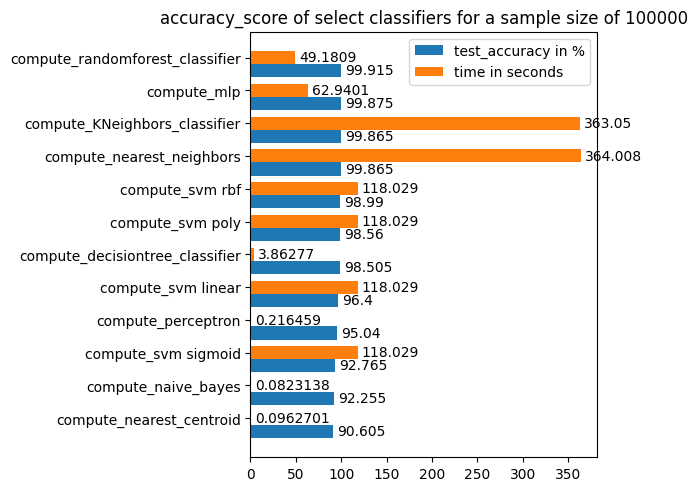

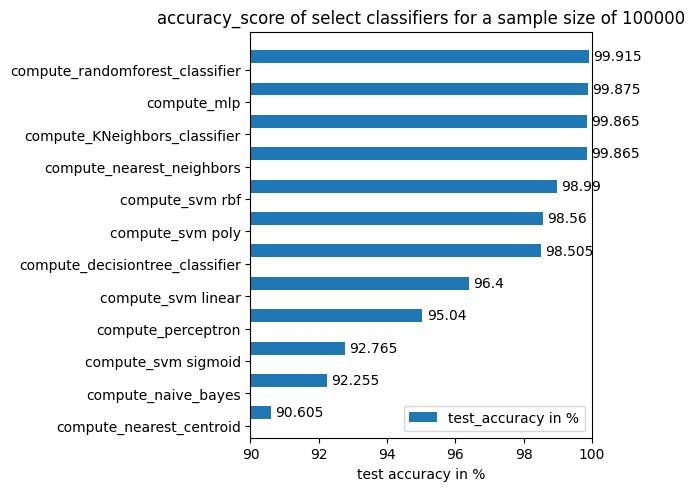

In [24]:
from matplotlib.axes import Axes
TIME_IN_SECONDS_STRING = "time in seconds"
# sorting the testaccs by value... there has to be a better way...
sorted_list = sorted(testaccs_dict.items(), key=lambda x: x[1][0])
testacc_dict_sorted = {}
values0 = []
values1 = []
names = []
for key, values in sorted_list:
    names.append(key)
    values0.append(values[0])
    values1.append(values[1])
values0_tuple = tuple(values0)
testacc_dict_sorted = {"test_accuracy in %": tuple(values0), TIME_IN_SECONDS_STRING: tuple(values1)}

# GROUPED PLOTS from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# Plot 1
x = np.arange(len(testaccs_dict))  # the label locations
height = 0.4  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
ax: Axes = ax  # this line is necessary for code recommendations (seeing what methods the class has)..
for attribute, measurement in testacc_dict_sorted.items():
    offset = height * multiplier
    barContainers = ax.barh(x + offset, measurement, height, label=attribute)
    ax.bar_label(barContainers, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# plt.title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_yticks(x + height, names)
ax.legend(loc='upper right', ncols=1)
plt.show()

# Plot 2 with zoom in
fig, ax = plt.subplots(layout='constrained')
ax: Axes = ax  # this line is necessary for code recommendations (seeing what methods the class has)..
for attribute, measurement in testacc_dict_sorted.items():
    if (attribute == TIME_IN_SECONDS_STRING):
        continue
    offset = height * multiplier
    barContainers = ax.barh(x + offset, measurement, height, label=attribute)
    ax.bar_label(barContainers, padding=3)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
# plt.title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_title("accuracy_score of select classifiers for a sample size of "+str(amount_of_rows))
ax.set_xlabel('test accuracy in %')
ax.set_yticks(x + height, names)
# plt.legend(loc='upper left', ncols=3)
ax.legend(loc='lower right', ncols=1, labels=["test_accuracy in %"])
ax.set_xlim(90, 100)
plt.show()


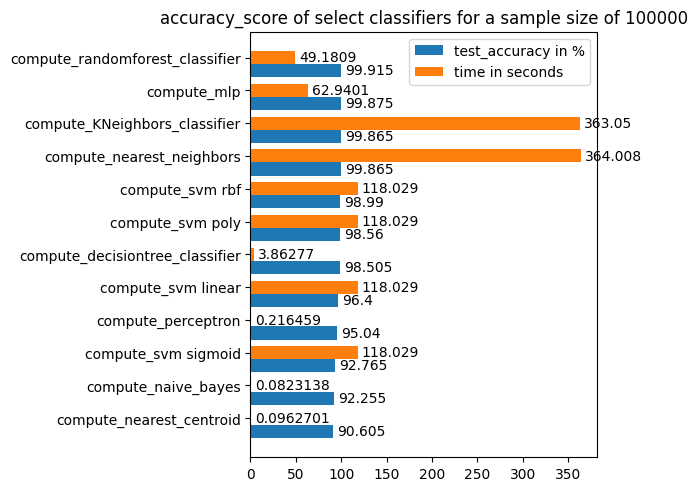

train accuracy: 98.61125 %
test accuracy: 98.505 %
classification_report train:
               precision    recall  f1-score   support

           0     0.9858    0.9864    0.9861     40035
           1     0.9864    0.9858    0.9861     39965

    accuracy                         0.9861     80000
   macro avg     0.9861    0.9861    0.9861     80000
weighted avg     0.9861    0.9861    0.9861     80000

classification_report test:
               precision    recall  f1-score   support

           0     0.9834    0.9870    0.9852     10065
           1     0.9868    0.9831    0.9849      9935

    accuracy                         0.9850     20000
   macro avg     0.9851    0.9850    0.9850     20000
weighted avg     0.9851    0.9850    0.9850     20000



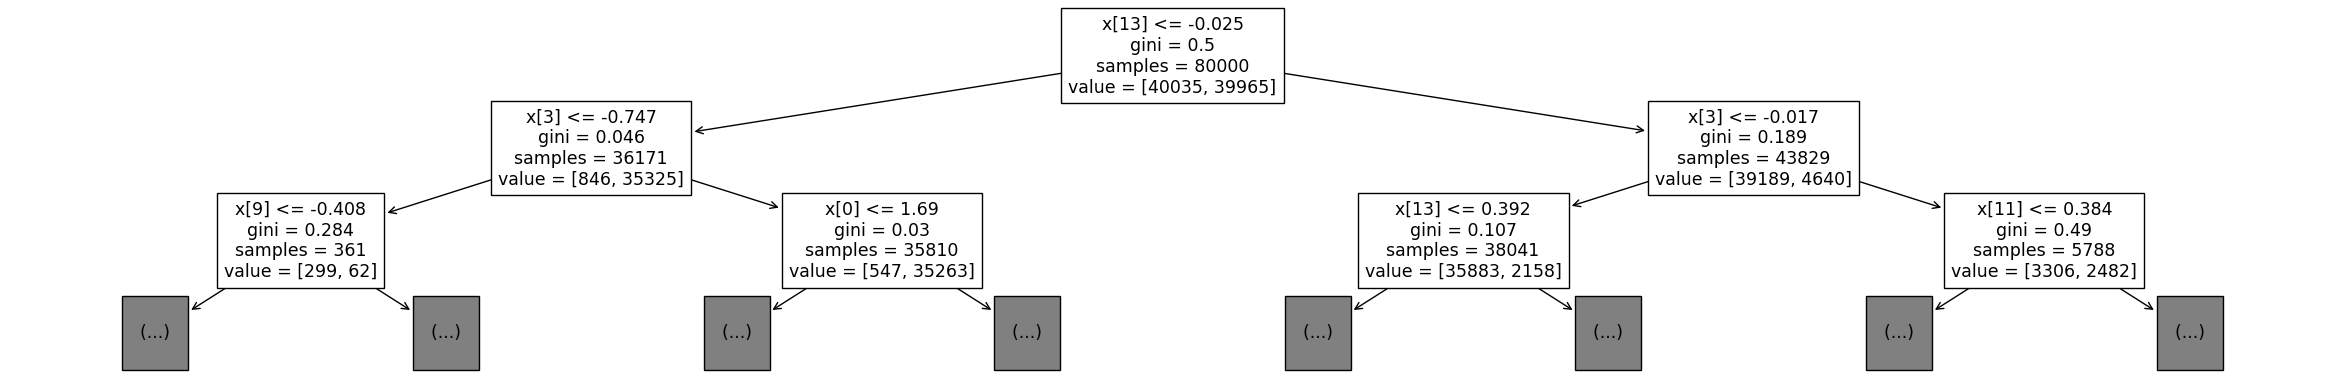

In [25]:
# classification report
mytree, trainaccs_svm, testaccs_svm = compute_decisiontree_classifier_tree_and_cm(df, max_depth=10)

fig, ax = plt.subplots()
fig.set_figwidth(30)
tree.plot_tree(mytree, max_depth=2)
plt.show()